In [0]:
!unzip ./Corpora.zip -d ./
!git clone https://github.com/OpenNMT/OpenNMT-py.git
!python ./OpenNMT-py/setup.py install
!pip install -U torchtext
!nvidia-smi
!mkdir ./data ./models ./predictions

In [0]:
def characterize(src_path, char_path):
    src_file = open(src_path, 'r')
    char_file = open(char_path, 'w')
    for line in src_file:
        words_list = line.rstrip().split(' ')
        chars_line = ''
        for word in words_list:
            for char in word:
                chars_line += char+' '
            chars_line += '<b> '
        char_file.write(chars_line[:-5]+'\n')

In [0]:
characterize(
    './Corpora/Transliteration/train.en', 
    './data/train.en'
)
characterize(
    './Corpora/Transliteration/train.fa', 
    './data/train.fa'
)
characterize(
    './Corpora/Transliteration/dev.en', 
    './data/dev.en'
)
characterize(
    './Corpora/Transliteration/dev.fa', 
    './data/dev.fa'
)
characterize(
    './Corpora/Transliteration/test.en', 
    './data/test.en'
)
characterize(
    './Corpora/Transliteration/test.fa', 
    './data/test.fa'
)

In [0]:
!python OpenNMT-py/preprocess.py \
-train_src ./data/train.fa \
-train_tgt ./data/train.en \
-valid_src ./data/dev.fa \
-valid_tgt ./data/dev.en \
-save_data ./data/trans \
-src_seq_length 100 \
-tgt_seq_length 100 \
-lower

In [0]:
!python OpenNMT-py/train.py \
-data ./data/trans \
-src_word_vec_size 512 \
-tgt_word_vec_size 512 \
-encoder_type "rnn" \
-decoder_type "rnn" \
-layers 6 \
-rnn_size 512 \
-rnn_type "LSTM" \
-save_model ./models/trans \
-save_checkpoint_steps 2500 \
-gpu_ranks 0 \
-world_size 1 \
-seed 2020 \
-batch_size 32 \
-normalization "sents" \
-train_steps 50000 \
-early_stopping 0 \
-optim "adam" \
-max_grad_norm 5 \
-dropout 0.4 \
-learning_rate 0.001 \
-learning_rate_decay 0.8 \
-start_decay_steps 10000 \
-decay_steps 5000 \
-decay_method "none" \
-warmup_steps 1000 \
-report_every 500 \
-log_file "stats.txt"

In [0]:
import os
import subprocess
import matplotlib.pyplot as plt

In [0]:
def execute(cmd):
    process = subprocess.Popen(
        cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    (result, error) = process.communicate()
    rc = process.wait()
    if rc != 0:
        print ("Error: failed to execute command: ", cmd)
        print (error.rstrip().decode("utf-8"))
    return result.rstrip().decode("utf-8"), error.rstrip().decode("utf-8")

In [0]:
def postprocess(src_path, save_path):
    src_file = open(src_path, 'r')
    save_file = open(save_path, 'w')
    for line in src_file:
        line = line.replace(' ', '')
        line = line.replace('<b>', ' ')
        save_file.write(line)

In [0]:
files_list = sorted(
    os.listdir('./models'), 
    key=lambda x: int(x[len('trans_step_'):-3])
)
bleu_file = open('bleu_results.txt', 'w')
for file in files_list:
    if file.startswith('trans'):
        num_step = int(file[len('trans_step_'):-3])
        pred_file = f'pred_step_{num_step}.txt'
        out = execute(f'python OpenNMT-py/translate.py \
        -model ./models/{file} \
        -src ./data/dev.fa \
        -output ./data/{pred_file} -replace_unk')
        postprocess(f'./data/{pred_file}', f'./predictions/{pred_file}')
        out = execute(f'perl OpenNMT-py/tools/multi-bleu.perl \
        ./Corpora/Transliteration/dev.en < ./predictions/{pred_file}')
        print(f'Model {file} evaluation finished.')
        print(out)
        bleu_file.write(f'{num_step} {out[0]}\n')
bleu_file.close()

In [0]:
!python OpenNMT-py/translate.py \
-model ./models/trans_step_50000.pt \
-src ./data/test.fa \
-output ./data/test.txt \
-replace_unk -verbose

In [0]:
postprocess('./data/test.txt', './predictions/test.txt')

In [0]:
!perl  OpenNMT-py/tools/multi-bleu.perl \
./Corpora/Transliteration/test.en < ./predictions/test.txt

In [0]:
results = open('./stats.txt', 'r')
accuracies = []
steps = []
perplexities = []
for line in results:
    line = line.rstrip()
    if 'acc:' in line:
        print(line)
        accuracies.append(
            float(line[line.index('acc:')+6:line.index('ppl:')-2])
        )
        perplexities.append(
            float(line[line.index('ppl:')+5:line.index('xent:')-2])
        )
        steps.append(
            int(line[line.index('Step')+5:line.index('/50000')])
        )

[2020-05-28 06:26:47,801 INFO] Step 500/50000; acc:  21.43; ppl: 15.09; xent: 2.71; lr: 0.00100; 5241/6970 tok/s;    114 sec
[2020-05-28 06:28:40,538 INFO] Step 1000/50000; acc:  24.14; ppl: 13.56; xent: 2.61; lr: 0.00100; 5285/7035 tok/s;    227 sec
[2020-05-28 06:30:34,950 INFO] Step 1500/50000; acc:  25.40; ppl: 13.01; xent: 2.57; lr: 0.00100; 5215/6943 tok/s;    342 sec
[2020-05-28 06:32:30,695 INFO] Step 2000/50000; acc:  26.03; ppl: 12.68; xent: 2.54; lr: 0.00100; 5184/6899 tok/s;    457 sec
[2020-05-28 06:34:26,089 INFO] Step 2500/50000; acc:  26.76; ppl: 12.40; xent: 2.52; lr: 0.00100; 5180/6900 tok/s;    573 sec
[2020-05-28 06:36:20,722 INFO] Step 3000/50000; acc:  33.34; ppl:  9.58; xent: 2.26; lr: 0.00100; 5204/6927 tok/s;    687 sec
[2020-05-28 06:38:15,762 INFO] Step 3500/50000; acc:  52.45; ppl:  4.72; xent: 1.55; lr: 0.00100; 5256/6995 tok/s;    802 sec
[2020-05-28 06:40:08,174 INFO] Step 4000/50000; acc:  60.44; ppl:  3.56; xent: 1.27; lr: 0.00100; 5270/7021 tok/s;    9

Text(0, 0.5, 'perplexity')

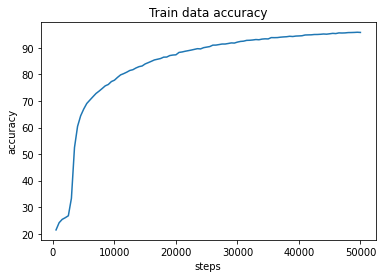

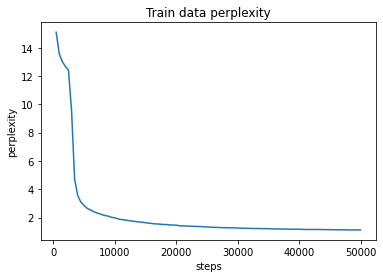

In [0]:
plt.plot(steps, accuracies)
plt.title('Train data accuracy')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.figure()
plt.plot(steps, perplexities)
plt.title('Train data perplexity')
plt.xlabel('steps')
plt.ylabel('perplexity')

In [0]:
results = open('./bleu_results.txt', 'r')
bleu_scores = []
steps = []
for line in results:
    line = line.rstrip()
    bleu_scores.append(
        float(line[line.index('BLEU')+7:line.index(',')])
    )
    steps.append(int(line[:line.index('BLEU')-3])*0.1)

Text(0, 0.5, 'BLEU')

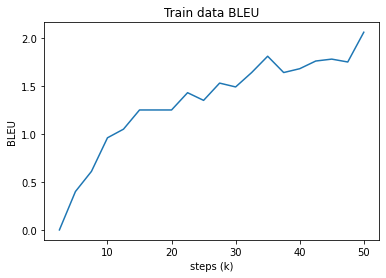

In [0]:
plt.figure()
plt.plot(steps, bleu_scores)
plt.title('Train data BLEU')
plt.xlabel('steps (k)')
plt.ylabel('BLEU')

In [0]:
def char_bleu(src_path, src_save_path, tgt_path, tgt_save_path):
    characterize(src_path, src_save_path)
    characterize(tgt_path, tgt_save_path)
    out = execute(f'perl OpenNMT-py/tools/multi-bleu.perl \
    {tgt_save_path} < {src_save_path}')
    return out[0]

In [0]:
charcter_bleu = char_bleu(
    './predictions/test.txt',
    './predictions/char_test.txt',
    './Corpora/Transliteration/test.en',
    './data/char_test.en'
)

In [16]:
print(f'character bleu: {charcter_bleu}')

character bleu: BLEU = 30.82, 81.0/49.9/27.8/17.6 (BP=0.822, ratio=0.836, hyp_len=60152, ref_len=71938)
